In [1]:
import itertools
import ast

import pandas as pd
import numpy as np
import sqlite3

from contextlib import closing

from tqdm import tqdm
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from plotnine import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get playlerid mapping
from pymlb.util.utils import get_config
from pymlb.util.database import database_mlb_engine

config = get_config()
engine = database_mlb_engine()

# Read player id data
player_id_url = config["data"]["download_urls"]["player_id_map"]
player_id_data = pd.read_csv(player_id_url, low_memory=False)

# Get player ID of Chris Sale
player_id_data[(player_id_data.name_last.str.lower() == "sale") &
               (player_id_data.name_first.str.lower() == "chris")]



key_person                              key_uuid  key_mlbam key_retro  \
247164   be790f8a  be790f8a-e8b9-465a-a2e9-2ca654cf8819   519242.0  salec001   

       key_bbref key_bbref_minors  key_fangraphs  key_npb key_sr_nfl  \
247164  salech01     sale--001chr        10603.0      NaN        NaN   

       key_sr_nba  ... pro_managed_first  pro_managed_last mlb_managed_first  \
247164        NaN  ...               NaN               NaN               NaN   

       mlb_managed_last col_managed_first col_managed_last pro_umpired_first  \
247164              NaN               NaN              NaN               NaN   

       pro_umpired_last  mlb_umpired_first  mlb_umpired_last  
247164              NaN                NaN               NaN  

[1 rows x 40 columns]

In [194]:
def get_pitches_for_pitcher(pitch_id, return_only_final_pitch=False):
    # Get all pitches for one player (Chris Sale)
    with closing(sqlite3.connect("data/mlb.db")) as con:

        pitches = pd.read_sql(f"SELECT * from pitchFx where pit_mlbid = {pitch_id}", con)

        
    pitches["atbat_key"] = (
        pitches.date.astype(str)
        + pitches.home_team.astype(str)
        + pitches.away_team.astype(str)
        + pitches.inning_num.astype(str)
        + pitches.bat_mlbid.astype(str)
        + pitches.pit_mlbid.astype(str)
    )
        
    if return_only_final_pitch:
        final_pitch_index = pitches.groupby(['atbat_key'])['at_bat_pitch_counter'].transform(max) == pitches['at_bat_pitch_counter']
        pitches = pitches[final_pitch_index].reset_index(drop=True)

    return pitches
        

In [195]:
pitches = get_pitches_for_pitcher(519242)

### What types of pitches does sale throw?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [297]:
def clean_pitch_data(pitches_df: DataFrame,
                     drop_irrelevant_pitches: bool=True,
                     drop_unknown: bool=True,
                     drop_incomplete_atbats: bool=False,
                     impute_unknown: bool=True):
    '''
    pitches: DataFrame output from get_pitches_for_pitcher()
    drop_irrelevant_pitches: Determines if pitchout and other intentaionlly "bad" pitches are removed
    drop_unknown: There are often pitches that have '' listed as pitches and no information at all.
        These can be conditionally removed
    drop_incomplete_atbats: If a pitch is removed via one of the above means, determines if the entire atbat should be
        removed or not
    impute_unknown: Assume piches thrown less than 1% of the time are missclassified and "unknown" pitch types.  These will
        be imputed with a 10 tree random forest
    '''
    
    pitches = pitches_df.copy().reset_index(drop=True)
    
    if drop_irrelevant_pitches:
        # Drop at bats with "IN", "PO" b/c they are not particularly meaningful for our usecase 
        irrelevant_pitch_index = pitches[pitches.pitch_type.isin(["IN", "PO"])].index
        pitches = pitches[~pitches.atbat_key.isin(invalid_atbats)]
    else:
        irrelevant_pitch_index =[]
    
    if drop_unknown:
        # Pitches that are '' have literally no data availalbe for them. Drop.
        # UN are unknown as well
        unknown_pitch_index = pitches[pitches.pitch_type.isin(["", "UN"])].index
    else:
        unknown_pitch_index = []
        
    # Atbats will only be incomplete if we remove relevant pitches vie the above conditions
    remove_pitches_index = pd.Index.union(irrelevant_pitch_index, unknown_pitch_index)
    if drop_incomplete_atbats and (drop_irrelevant_pitches or drop_unknown):
        atbats_to_remove = pitches.iloc[remove_pitches_index].atbat_key
        pitches = pitches[~pitches.atbat_key.isin(atbats_to_remove)].reset_index(drop=True)
        
    else:
        pitches = pitches[~remove_pitches_index].reset_index(drop=True)
    
    
    # TODO: Make these cleaning fucntions a class and add this as a seperate method
    pitch_frequencies = pitches.pitch_type.value_counts(normalize=True, dropna=False)
    
    missclassified_pitch_types = pitch_frequencies[pitch_frequencies < .01].index.values

    x_features = ["pitch_ax",
                      "pitch_ay",
                      "pitch_az",
                      "pitch_break_angle",
                      "pitch_break_length",
                      "pitch_break_y",
                      "pitch_nasty_factor",
                      "pitch_spin_dir",
                      "pitch_spin_rate",
                      "pitch_start_speed",
                      "pitch_end_speed",
                      "pitch_pfx_x",
                      "pitch_pfx_z",
                      "pitch_px",
                      "pitch_pz",
                      "pitch_vx0",
                      "pitch_vy0",
                      "pitch_vz0",
                      "pitch_x",
                      "pitch_x0",
                      "pitch_y",
                      "pitch_y0",
                      "pitch_z0",]
    
    # Impute any missing values
    # TODO: Be smarter and more proceduralized about this
    impute_vals = pitches[x_features].mean()

    for col in x_features:
        pitches.loc[pitches[col].isna(), col] = impute_vals[col]
    
    pitches_unknown = pitches[pitches.pitch_type.isin(missclassified_pitch_types)]
    pitches_known = pitches[(~pitches.pitch_type.isin(missclassified_pitch_types))]
    
    if pitches_unknown.shape[0] > 0:
        
        # Use RF to predict missing pitch types
        rf = RandomForestClassifier(n_estimators=10)
        rf.fit(pitches_known_train[x_features], pitches_known_train.pitch_type)

        pitches_unknown['pitch_type'] = rf.predict(pitches_unknown[x_features])

        return pd.concat([pitches_known, unknown_pitches]).reset_index(drop=True)
    else:
        return pitches
    
    

In [262]:
c = clean_pitch_data(pitches, True, True, True, True)

## Train markov model to understand pitch sequences better

In [273]:
from typing import List, Optional
from collections import Counter

In [271]:
pitches_clean.sort_values(['atbat_key', 'at_bat_pitch_counter'], inplace=True)
all_at_bat_seq = pitches_clean.groupby(['atbat_key'])['pitch_type'].apply(list)

In [277]:
class Markov:
    
    def __init__(self, all_seq: List[List]):
        '''
        seq (List[List[str]]): List of sequences of states
        '''
        self.all_seq=all_seq
        
        # Find initial probabilities
        # Get first element of each sequence
        init_state = [indiv_seq[0] for indiv_seq in all_seq]
        init_probs = pd.Series(init_state).value_counts(normalize=True)
        self.init_probs = init_probs
        
        # Determine transition probabilities
        # Define tuples of pitch to pitch
        trans_states = [self._get_sequential_pairs(indiv_seq.copy()) for indiv_seq in all_seq]
        trans_probs = pd.Series(self._join_list(trans_states)).value_counts(normalize=True)
        self.trans_probs = trans_probs
        
    def _get_sequential_pairs(self, seq: List, add_termination_state: bool=True) -> List[List[str]]:
        
        # Add a dummy termination state if requested
        if add_termination_state:
            seq.append("X")

        pairs = []
        for idx in range(0, len(seq)):
            if idx != len(seq)-1:
                pairs.append(str(seq[idx:idx+2]))

        return pairs

    def get_sample_seq_terminal(self, init_state: Optional[str]=None):
        '''
        Generates a sample sequence until the termination character X is encountered
        
        init_state: An optional paramter defining the initial state desired by a user. Otherwise, this will be probabilistically
                    sampled from initial states probabilities.
        '''
        
        if init_state is not None:
            # Check initial state is in initial_probabilities
            if not (init_state in a.init_probs.keys()):
                raise Exception("Input initial state not found in data!")
        else:
            # Randomly sample initial state if user has not provided one
            init_state = np.random.choice(self.init_probs.keys(), p=self.init_probs.values)
        
        # Keep sampling until terminal character is hit
        keys = [ast.literal_eval(key) for key in self.trans_probs.keys()]
        cur_state = init_state
        gen_seq = [cur_state]
        while True:
            
            new_state_info = [(item[1], idx) for idx, item in enumerate(keys) if item[0] == cur_state]
            new_state = [item[0] for item in new_state_info]
            new_state_idx = [item[1] for item in new_state_info]
            
            new_state_trans_probs = self.trans_probs.iloc[new_state_idx]
            
            # Normalize probs
            new_state_trans_probs_norm = self._normalize_probabilities(new_state_trans_probs)
        
            # Sample new state from relevant transition probabilities
            new_state = np.random.choice(new_state, p=new_state_trans_probs_norm)
            
            gen_seq.append(new_state)
            if new_state == 'X':
                break
                
        return gen_seq
        
    def _flatten_list(self, input_list: List[List]) -> List:
        flat_list = [item for sublist in input_list for item in sublist]

        return flat_list
    
    def _join_list(self, input_list: List[List]) -> List:
        joined_list = list(itertools.chain.from_iterable(input_list))

        return joined_list
    
    def _normalize_probabilities(self, input_list) -> List[float]:
        '''
        Normalizes probs (makes them sum to 1)
        '''
        
        tot = np.sum(input_list)
        
        return np.array(input_list) / tot
        

In [278]:
pitch_markov = Markov(all_at_bat_seq)

Sample 10000 at-bats and see how pitch at-bat pitch lengths match to our empirical distribution

In [279]:
# NOTE: All theoretical atbats get 1 subtracted from them, as the "exit" state isn't an actual pitch thrown (just signifies the atbat is over)
atbat_sample_pitch_lengths = [len(pitch_markov.get_sample_seq_terminal())-1 for _ in tqdm(range(0, 10000))]
atbat_sample_pitch_lengths = pd.DataFrame(data={'atbat_len_sample': atbat_sample_pitch_lengths})


 92%|█████████▏| 9194/10000 [00:15<00:01, 611.75it/s]


100%|██████████| 10000/10000 [00:16<00:00, 616.59it/s]

In [280]:
atbat_actual_pitch_lengths = pd.DataFrame(data={'atbat_len_actual': all_at_bat_seq.apply(len)})

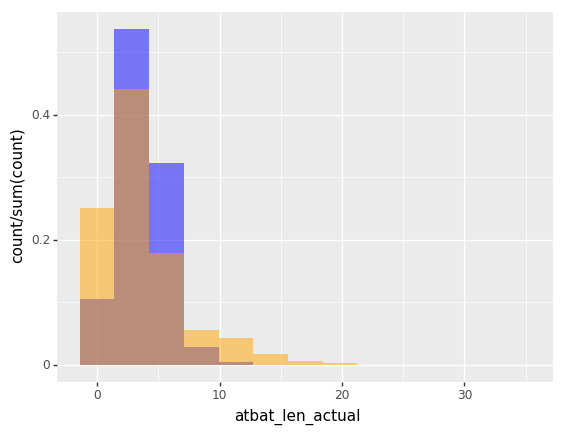

<ggplot: (-9223372029283782007)>

In [281]:
(ggplot() +
    geom_histogram(aes(x='atbat_len_actual', y ='..count../sum(..count..)'), data=atbat_actual_pitch_lengths, bins=13, fill='blue', alpha=.5) +
    geom_histogram(aes(x='atbat_len_sample', y='..count../sum(..count..)'), data=atbat_sample_pitch_lengths, bins=13, fill='orange', alpha=.5))


It appears our markov model grossly overestimates the likelyhood of "one pitch and done" at bats as well as extremely long atbats.

- In this context, we are completely ignoring the behavior of hitters who in certain cases may be more or less likely to actually swing in various scenarios. 

- We completely ignore strikeouts or walks.  In the cases where an AB is 20 pitches, it is more than likely that a walk or strikeout would have occurred before a player would foul off that many pitches

- Ignored count.  This could easily be incorporated into the state; however, we may run into sparsity issues when players don't have a ton of atbats


# Ideas
- I don't think the markov chain should add a terminal note.  I should have a model on top of the pitches that probabilistically determines if the outcome was a strike/ball/hit/out/etc.

- The idea that the current pitch depends only on the previous pitch is quite naive.  In reality, it depends on the count, how the batter responded to a particular pitch, the batter's handedness, etc.  A more robust model would nearly certainly be better
- Do HMMs lend themselves nicely here?  Particularly for generation of pitch locations?  For example, a markov chain will simply give a pitch but will not give charactoristics of the pitch such as speed, location, etc.  You can imagine, though, the sequence of pitches could impact where a pitcher would opt to throw the ball.  If a hitter just whiffed 2 fastballs high and tight, is it more likely a pitcher will go back to that pitch? 
- The likelihood of throwing certain pitches changes based on context.   A pitcher may not throw a ton of "junk" if the bases are loaded and the can't walk someone. 

#### Try fitting a multinomial distribution to indivual pitches and sampling them

# Ideas
- Instead of trying to simulate new data, why not simply bootstrap from existing data?  Given the large number of parameters that go into what a "pitch" is (type, speed, handedness, spin, spin direction, etc.)

In [708]:
cur_pitch_type = "SL"

In [741]:
pitches_clean[pitches_clean.pitch_type == pitch_type].sample()

date home_team away_team  inning_num bat_mlbid pit_mlbid bat_hand  \
5384  2013-05-12       cha       ana           6    455104    519242        R   

     pit_hand  away_team_runs  home_team_runs  ... pitch_x0 pitch_y  pitch_y0  \
5384        L               0               0  ...    3.009  152.83      50.0   

      pitch_z0  pitch_zone  pitch_time_zulu  pitch_nasty_factor_impute_x  \
5384     5.206         5.0                                     43.295772   

      pitch_nasty_factor_impute_y  pitch_nasty_factor_impute  \
5384                    43.295772                  43.295772   

                          atbat_key  
5384  2013-05-12chaana6455104519242  

[1 rows x 46 columns]

# Build a gradient of hot/cold zones

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
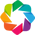

In [27]:
import numpy as np
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt

In [302]:
from pandas.core.frame import DataFrame
from typing import List

In [303]:
def strikezone():    
    hlines = [hv.HLine(hline).opts(opts.HLine(color='black', line_dash='dashed',  line_width=3)) for hline in [1.6, 3.5583]]
    vlines = [hv.VLine(vline).opts(opts.VLine(color='black', line_dash='dashed',  line_width=3)) for vline in [-.825, .825]]
    
    return hv.Overlay(vlines + hlines)

In [304]:
def plot_pitch_density(df: DataFrame, bandwidth=.5, show_strikezone=True) -> List[List]:
    '''
    Produces a faceted grid of KDEs of pitches.
    
    df: A dataframe containing bat_hand, pitch_px, pitch_pz, pitch_type
    
    '''
    all_plots = []
    for hand in ['L', 'R']:
        plots_hand = []
        for pitch_type in df.pitch_type.unique():
            plot = (hv.Bivariate(outcomes[(df.bat_hand == hand) &
                                          (df.pitch_type == pitch_type)][['pitch_px', 'pitch_pz']], label=f"{hand}-{pitch_type}")
                       .options(bandwidth=bandwidth, filled=True, cmap="Blues"))
            
            if show_strikezone:
                plot = hv.Overlay([plot] + [strikezone()])
            
            plots_hand.append(plot)
        all_plots.append(plots_hand)

    layout = hv.Layout(all_plots[0] + all_plots[1]).cols(len(list(plots[0].values())))
        
    return layout
        

In [314]:
def map_outcomes_to_general_contact_types(df):
    """
    Takes as input a dataframe with a column at_bat_outcome. Said column will be remapped to contact type events (line, ground, fly, bunt, non-contact) called general_contact_types
    and a pd.DataFrame will be returned

    Input:
        df (pd.DataFrame)

    Output:
        df (pd.DataFrame)

    """

    general_contact_type_mapping = {
        "batter interference": "non_contact",
        "bunt ground Out": "bunt",
        "bunt groundout": "bunt",
        "bunt lineout": "bunt",
        "bunt pop out": "bunt",
        "catcher interference": "non_contact",
        "double": "double",
        "double play": "double play",
        "fan interference": "non_contact",
        "field error": "error",
        "fielders choice": "ground",
        "fielders choice out": "ground",
        "fly out": "fly",
        "flyout": "fly",
        "force out": "forceout",
        "forceout": "forceout",
        "ground out": "ground",
        "grounded into dp": "ground",
        "groundout": "ground",
        "hit by pitch": "non_contact",
        "home run": "home run",
        "intent walk": "non_contact",
        "line out": "line",
        "lineout": "line",
        "pop out": "fly",
        "runner out": "non_contact",
        "sac bunt": "bunt",
        "sac fly": "fly",
        "sac fly dp": "fly",
        "sacrifice bunt dp": "bunt",
        "single": "single",
        "strikeout": "non_contact",
        "strikeout - dp": "non_contact",
        "triple": "triple",
        "triple play": "triple play",
        "walk": "non_contact",
    }

    df["general_contact_types"] = df.at_bat_outcome.str.lower()

    # Apply new labels
    df.general_contact_types = df.general_contact_types.map(
        general_contact_type_mapping
    )

    # Replace NaN values with at_bat_outcome
    df.general_contact_types.fillna(df.at_bat_outcome, inplace=True)

    # Check where general labels can be made more specific and adjust label to groundout, flyout, or lineout appropriately
    df.loc[
        (df.general_contact_types == "forceout")
        & (df.at_bat_outcome_description.str.contains(" ground")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "forceout")
        & (df.at_bat_outcome_description.str.contains(" flies")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "forceout")
        & (df.at_bat_outcome_description.str.contains(" pops")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "forceout")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "forceout")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"

    df.loc[
        (df.general_contact_types == "double play")
        & (df.at_bat_outcome_description.str.contains(" ground")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "double play")
        & (df.at_bat_outcome_description.str.contains(" flies")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "double play")
        & (df.at_bat_outcome_description.str.contains(" pops")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "double play")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "double play")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"

    df.loc[
        (df.general_contact_types == "triple play")
        & (df.at_bat_outcome_description.str.contains(" ground")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "triple play")
        & (df.at_bat_outcome_description.str.contains(" flies")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "triple play")
        & (df.at_bat_outcome_description.str.contains(" pops")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "triple play")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "triple play")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"

    # NOTE: There are a small number of hits that were also double plays that are counted as "hit-Out in this ins"

    # Categorize hits as linedrive hits, groundball hits, or flyball hits
    df.loc[
        (df.general_contact_types == "single")
        & (df.at_bat_outcome_description.str.contains(" bunt")),
        "general_contact_types",
    ] = "bunt"
    df.loc[
        (df.general_contact_types == "single")
        & (df.at_bat_outcome_description.str.contains(" ground ball")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "single")
        & (df.at_bat_outcome_description.str.contains(" fly ball")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "single")
        & (df.at_bat_outcome_description.str.contains(" pop up")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "single")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "single")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"
    df.loc[df.general_contact_types == "single", "general_contact_types"] = "ground"

    df.loc[
        (df.general_contact_types == "double")
        & (df.at_bat_outcome_description.str.contains(" bunt")),
        "general_contact_types",
    ] = "bunt"
    df.loc[
        (df.general_contact_types == "double")
        & (df.at_bat_outcome_description.str.contains(" ground ball")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "double")
        & (df.at_bat_outcome_description.str.contains(" fly ball")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "double")
        & (df.at_bat_outcome_description.str.contains(" pop up")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "double")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "double")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"
    df.loc[df.general_contact_types == "double", "general_contact_types"] = "line"

    df.loc[
        (df.general_contact_types == "triple")
        & (df.at_bat_outcome_description.str.contains(" bunt")),
        "general_contact_types",
    ] = "bunt"
    df.loc[
        (df.general_contact_types == "triple")
        & (df.at_bat_outcome_description.str.contains(" ground ball")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "triple")
        & (df.at_bat_outcome_description.str.contains(" fly ball")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "triple")
        & (df.at_bat_outcome_description.str.contains(" pop up")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "triple")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "triple")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"
    df.loc[df.general_contact_types == "triple", "general_contact_types"] = "line"

    df.loc[
        (df.general_contact_types == "home run")
        & (df.at_bat_outcome_description.str.contains(" ground ball")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "home run")
        & (df.at_bat_outcome_description.str.contains(" fly ball")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "home run")
        & (df.at_bat_outcome_description.str.contains(" pop up")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "home run")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "home run")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "home run")
        & (df.at_bat_outcome_description.str.contains(" grand slam")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "home run"), "general_contact_types"
    ] = "fly"  # Default remaining homeruns to fly (more likely than line)

    df.loc[
        (df.general_contact_types == "error")
        & (df.at_bat_outcome_description.str.contains(" bunt")),
        "general_contact_types",
    ] = "bunt"
    df.loc[
        (df.general_contact_types == "error")
        & (df.at_bat_outcome_description.str.contains(" ground ball")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "error")
        & (df.at_bat_outcome_description.str.contains(" fly ball")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "error")
        & (df.at_bat_outcome_description.str.contains(" pop up")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "error")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "error")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"
    df.loc[df.general_contact_types == "error", "general_contact_types"] = "ground"

    # Ground Rule Doubles are often not classified appropritely
    df.loc[
        (df.at_bat_outcome_description.str.contains(" ground-rule double"))
        & (df.at_bat_outcome_description.str.contains(" bunt")),
        "general_contact_types",
    ] = "bunt"
    df.loc[
        (df.at_bat_outcome_description.str.contains(" ground-rule double"))
        & (df.at_bat_outcome_description.str.contains(" ground ball")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.at_bat_outcome_description.str.contains(" ground-rule double"))
        & (df.at_bat_outcome_description.str.contains(" fly ball")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.at_bat_outcome_description.str.contains(" ground-rule double"))
        & (df.at_bat_outcome_description.str.contains(" pop up")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.at_bat_outcome_description.str.contains(" ground-rule double"))
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.at_bat_outcome_description.str.contains(" ground-rule double"))
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"

    # Interference often has an actual play associated with it and is not always a non-contact event (interference)
    df.loc[
        (df.general_contact_types == "non_contact")
        & (df.at_bat_outcome_description.str.contains(" bunt")),
        "general_contact_types",
    ] = "bunt"
    df.loc[
        (df.general_contact_types == "non_contact")
        & (df.at_bat_outcome_description.str.contains(" ground ball")),
        "general_contact_types",
    ] = "ground"
    df.loc[
        (df.general_contact_types == "non_contact")
        & (df.at_bat_outcome_description.str.contains(" fly ball")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "non_contact")
        & (df.at_bat_outcome_description.str.contains(" pop up")),
        "general_contact_types",
    ] = "fly"
    df.loc[
        (df.general_contact_types == "non_contact")
        & (df.at_bat_outcome_description.str.contains(" lines")),
        "general_contact_types",
    ] = "line"
    df.loc[
        (df.general_contact_types == "non_contact")
        & (df.at_bat_outcome_description.str.contains(" line drive")),
        "general_contact_types",
    ] = "line"

    # Default Remaining unadjusted hits to "Hit-Unknown" and outs to "Out-Unknown"
    df.loc[
        df.general_contact_types.isin(["single", "double", "triple", "home run"]),
        "general_contact_types",
    ] = "unknown"
    df.loc[
        df.general_contact_types.isin(["forceout", "double play", "triple play"]),
        "general_contact_types",
    ] = "ground"

    # In the way the data is coded, there is no way to know if a fielders choice was a grounder, linedrive, or flyout
    # Assumption: most fielders choices are likely infield gorunders with a forceout to a leading runner
    df.loc[
        (df.general_contact_types == "fielders choice"), "general_contact_types"
    ] = "ground"

    return df

In [315]:
pitches_outcomes = get_pitches_for_pitcher(519242, return_only_final_pitch=True)
pitches_outcomes_clean = clean_pitch_data(pitches_outcomes, True, True, True, True)
pitches_outcomes_clean = map_outcomes_to_general_contact_types(pitches_outcomes_clean)

In [306]:
# outcomes = pitches_outcomes_clean[(pitches_outcomes_clean.at_bat_outcome == 'Strikeout')]

In [320]:
outcomes = pitches_outcomes_clean[(pitches_outcomes_clean.general_contact_types == 'ground')]

In [317]:
pitches_outcomes_clean.general_contact_types.unique()

array(['non_contact', 'line', 'ground', 'fly', 'bunt'], dtype=object)

In [321]:
plot_pitch_density(outcomes, bandwidth=.3)

:Layout
   .Overlay.L_hyphen_minus_SL :Overlay
      .Bivariate.L_hyphen_minus_SL :Bivariate   [pitch_px,pitch_pz]   (Density)
      .VLine.I                     :VLine   [x,y]
      .VLine.II                    :VLine   [x,y]
      .HLine.I                     :HLine   [x,y]
      .HLine.II                    :HLine   [x,y]
   .Overlay.L_hyphen_minus_CH :Overlay
      .Bivariate.L_hyphen_minus_CH :Bivariate   [pitch_px,pitch_pz]   (Density)
      .VLine.I                     :VLine   [x,y]
      .VLine.II                    :VLine   [x,y]
      .HLine.I                     :HLine   [x,y]
      .HLine.II                    :HLine   [x,y]
   .Overlay.L_hyphen_minus_FT :Overlay
      .Bivariate.L_hyphen_minus_FT :Bivariate   [pitch_px,pitch_pz]   (Density)
      .VLine.I                     :VLine   [x,y]
      .VLine.II                    :VLine   [x,y]
      .HLine.I                     :HLine   [x,y]
      .HLine.II                    :HLine   [x,y]
   .Overlay.L_hyphen_minus_FF :Overlay
      .Bivariate.L_hyphen_minus_FF :Bivariate   [pitch_px,pitch_pz]   (Density)
      .VLine.I                     :VLine   [x,y]
      .VLine.II                    :VLine   [x,y]
      .HLine.I                     :HLine   [x,y]
      .HLine.II                    :HLine   [x,y]
   .Overlay.R_hyphen_minus_SL :Overlay
      .Bivariate.R_hyphen_minus_SL :Bivariate   [pitch_px,pitch_pz]   (Density)
      .VLine.I                     :VLine   [x,y]
      .VLine.II                    :VLine   [x,y]
      .HLine.I                     :HLine   [x,y]
      .HLine.II                    :HLine   [x,y]
   .Overlay.R_hyphen_minus_CH :Overlay
      .Bivariate.R_hyphen_minus_CH :Bivariate   [pitch_px,pitch_pz]   (Density)
      .VLine.I                     :VLine   [x,y]
      .VLine.II                    :VLine   [x,y]
      .HLine.I                     :HLine   [x,y]
      .HLine.II                    :HLine   [x,y]
   .Overlay.R_hyphen_minus_FT :Overlay
      .Bivariate.R_hyphen_minus_FT :Bivariate   [pitch_px,pitch_pz]   (Density)
      .VLine.I                     :VLine   [x,y]
      .VLine.II                    :VLine   [x,y]
      .HLine.I                     :HLine   [x,y]
      .HLine.II                    :HLine   [x,y]
   .Overlay.R_hyphen_minus_FF :Overlay
      .Bivariate.R_hyphen_minus_FF :Bivariate   [pitch_px,pitch_pz]   (Density)
      .VLine.I                     :VLine   [x,y]
      .VLine.II                    :VLine   [x,y]
      .HLine.I                     :HLine   [x,y]
      .HLine.II                    :HLine   [x,y]

#### Fastball
- FA = fastball
- FF = four-seam fastball
- FT = two-seam fastball
- FC = fastball (cutter)
- FS / SI / SF = fastball (sinker, split-fingered)

#### Offspeed
- SL = slider
- CH = changeup
- CB / CU = curveball
- KC = knuckle-curve
- KN = knuckleball
- EP = eephus


#### OTHER
- UN / XX = unidentified
- PO / FO = pitch out



In [40]:
pitches.columns

Index(['date', 'home_team', 'away_team', 'inning_num', 'bat_mlbid',
       'pit_mlbid', 'bat_hand', 'pit_hand', 'away_team_runs', 'home_team_runs',
       'at_bat_outcome', 'at_bat_outcome_description', 'at_bat_pitch_counter',
       'pitch_ax', 'pitch_ay', 'pitch_az', 'pitch_break_angle',
       'pitch_break_length', 'pitch_break_y', 'pitch_batting_count_type',
       'pitch_type', 'pitch_type_confidence', 'pitch_outcome_description',
       'pitch_nasty_factor', 'pitch_pfx_x', 'pitch_pfx_z', 'pitch_px',
       'pitch_pz', 'pitch_spin_dir', 'pitch_spin_rate', 'pitch_start_speed',
       'pitch_end_speed', 'pitch_vx0', 'pitch_vy0', 'pitch_vz0', 'pitch_x',
       'pitch_x0', 'pitch_y', 'pitch_y0', 'pitch_z0', 'pitch_zone',
       'pitch_time_zulu'],
      dtype='object')

## Define general contact types